<a href="https://colab.research.google.com/github/thor4/protocol_labs/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Analysis of Filecoin Gas Dynamics
*Author: Bryan Conklin*
####[Source](https://github.com/thor4/protocol_labs/)
--- 
## Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Load and prepare the data
The dataset is comprised of per-minute network gas metrics which occurred between Jun 1, 2021 and Jun 25, 2021.

We will download a csv file from Google Drive then load its contents into a pandas dataframe, `df`.

The dataset has the following fields:

| Field | Unit | Note |  |  |
|---|---|---|---|---|
| mean_gas_fee_cap | attoFIL / GasUnit | price / gallon |  |  |
| mean_gas_premium | attoFIL / GasUnit | price / gallon |  |  |
| mean_gas_limit | GasUnit | gallons |  |  |
| mean_gas_used | GasUnit | gallons |  |  |
| mean_parent_base_fee | attoFIL / GasUnit | price / gallon, parent base fee is the base fee in the parent epoch |  |  |
| mean_base_fee_burned | attoFIL | total price |  |  |
| mean_over_estimation_burn | attoFIL | total price |  |  |
| mean_gas_refund | GasUnit | gallons |  |  |
| mean_gas_burned | GasUnit | gallons |  |  |

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/thor4/protocol_labs/main/dataset/derived_gas_outputs_minutes.csv', 
                 parse_dates=['timestamp'], infer_datetime_format=True)

In [3]:
df.head(3)

,Unnamed: 0,timestamp,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
0,0,2021-06-01 00:00:00+00:00,8.029010e+09,101728.474840,3.853911e+07,3.154444e+07,107.508692,3.344824e+09,1.379284e+08,5.712949e+06,1.281725e+06
1,1,2021-06-01 00:01:00+00:00,5.514969e+09,101091.411072,3.551579e+07,2.902460e+07,104.134276,2.964455e+09,1.137286e+08,5.395994e+06,1.095194e+06
2,2,2021-06-01 00:02:00+00:00,1.391597e+09,101666.874747,3.925006e+07,3.176285e+07,106.288889,3.336958e+09,1.693683e+08,5.889824e+06,1.597390e+06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34273 entries, 0 to 34272
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   Unnamed: 0                 34273 non-null  int64              
 1   timestamp                  34273 non-null  datetime64[ns, UTC]
 2   mean_gas_fee_cap           34273 non-null  float64            
 3   mean_gas_premium           34273 non-null  float64            
 4   mean_gas_limit             34273 non-null  float64            
 5   mean_gas_used              34273 non-null  float64            
 6   mean_parent_base_fee       34273 non-null  float64            
 7   mean_base_fee_burn         34273 non-null  float64            
 8   mean_over_estimation_burn  34273 non-null  float64            
 9   mean_gas_refund            34273 non-null  float64            
 10  mean_gas_burned            34273 non-null  float64            
dtypes:

## Figure 1. All Non-temporal Pairwise Relationships

Let's plot all non-temporal parameters against each other with histograms along the diagonal for reference. This is helpful in visualizing relationships within a dataset.

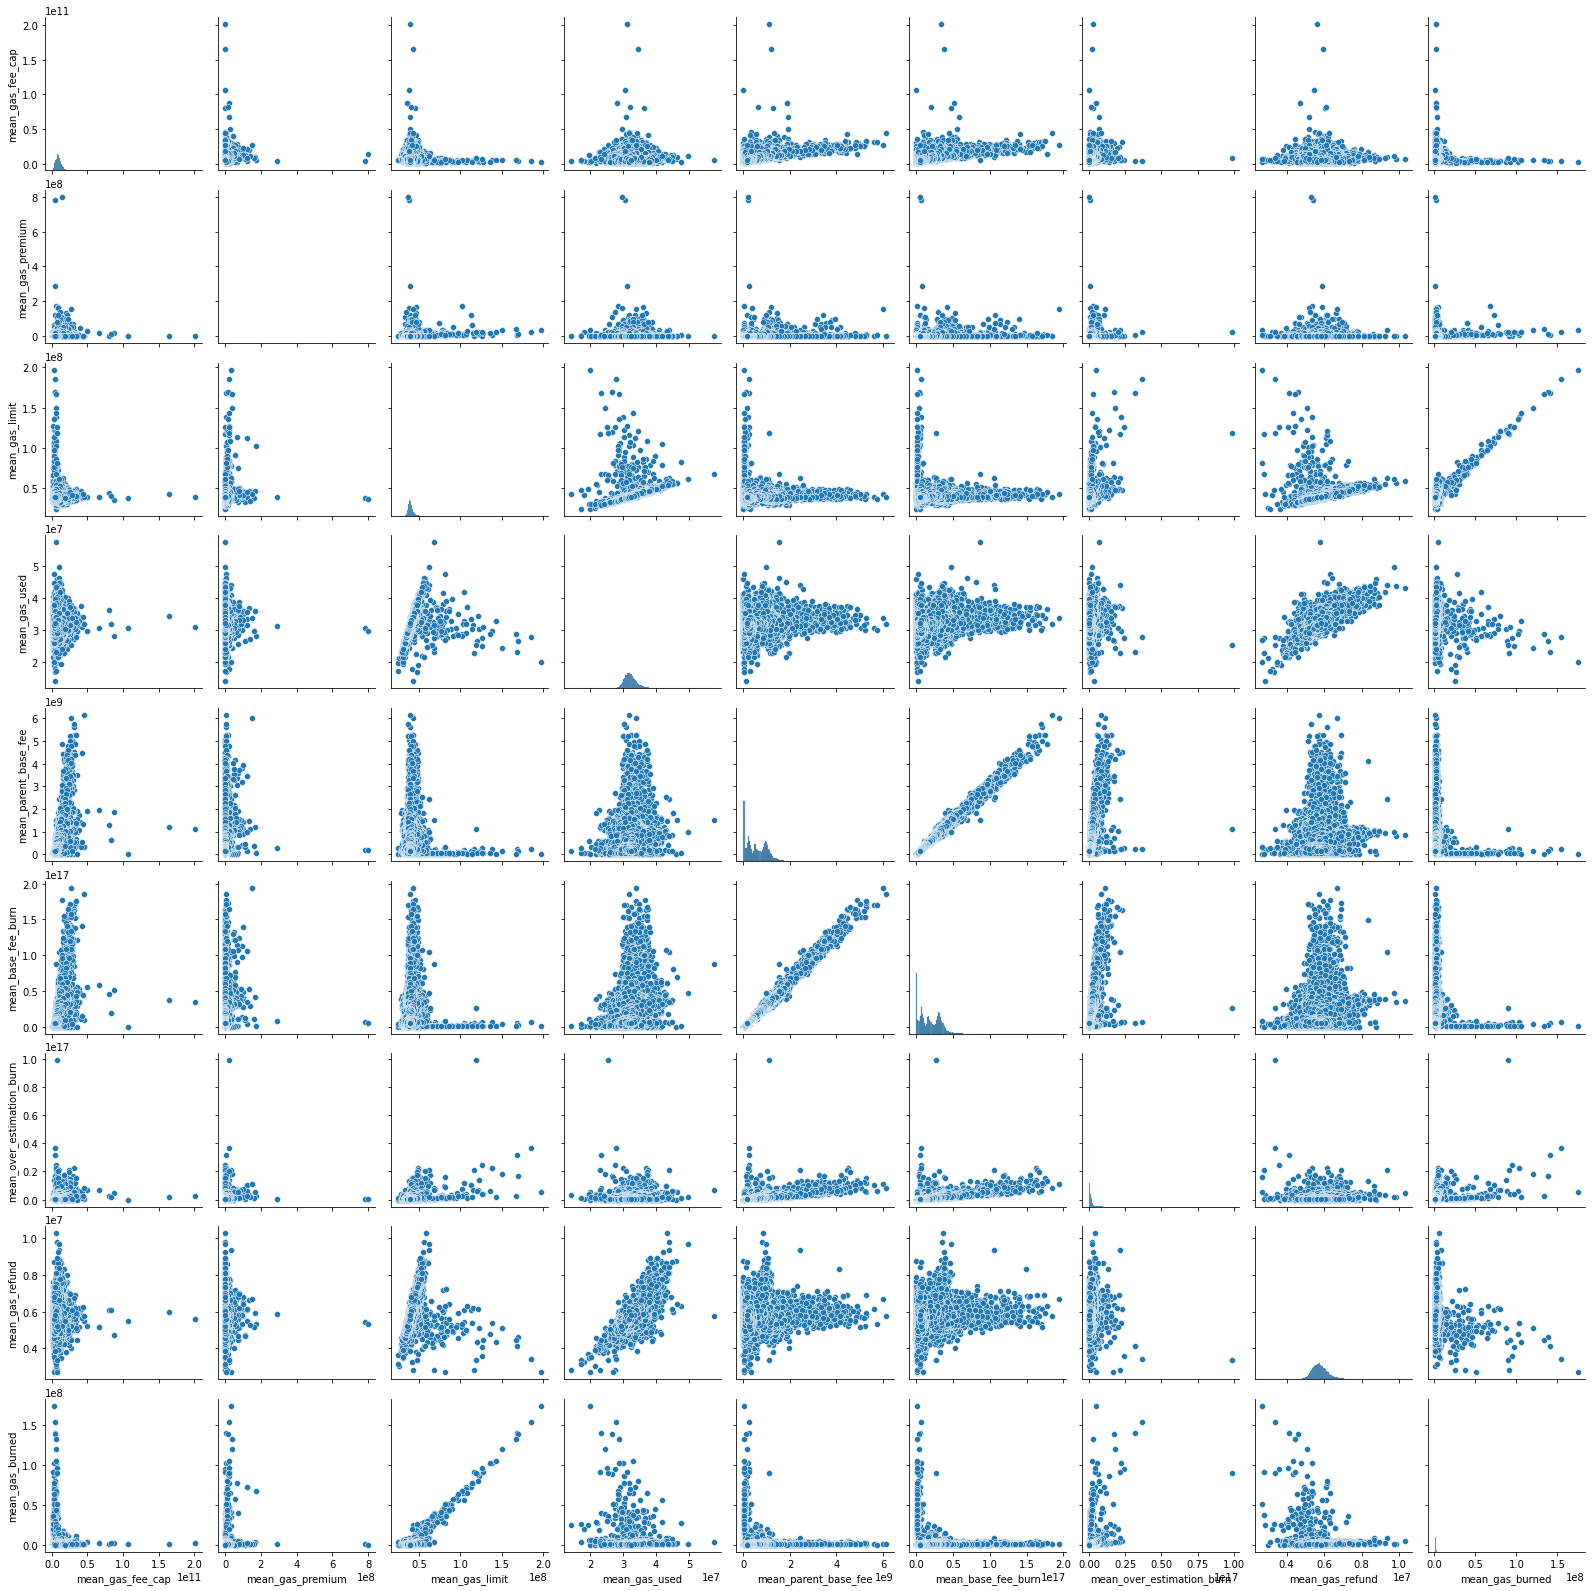

In [5]:
fig1b = sns.pairplot(data=df.iloc[:,2:])

There is a lot to parse in this figure. 

Certain parameters have a linear relationship. These include mean_gas_limit and mean_gas_burned (as the limit increases, so does the amount burned), mean_base_fee_burn and mean_parent_base_fee (as the parent base fee increases, the amount of the base fee burn increases), and the mean_gas_refund and mean_gas_used (as the gas used increases, so does the refund). All these relationships make sense and are good sanity checks.

It also seems like it would be more infomative to observe a few of the histograms in log-scale. The mean_gas_premium, in particular, doesn't even show up in this plot.

## Figure 2. Base Fee
With EIP 1559, the base fee changes as a function of network activity. If the previous block was filled more than the target gas limit, the block fee increases, up to 2 times the target. If the previous block contained less gas than the target, the base fee decreases. So, we can use the base fee in the dataset as a proxy for network activity. Let's see what its distribution looks like.

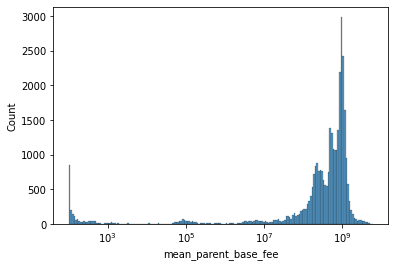

In [6]:
sns.histplot(data=df, x='mean_parent_base_fee', log_scale=True)

And now let's look at what percent each base fee range contributes toward the total distribution.

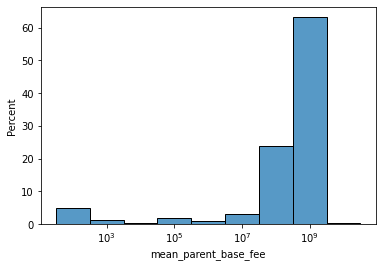

In [7]:
sns.histplot(data=df, x='mean_parent_base_fee', stat='percent', discrete=True, log_scale=True)

It looks like most of the activity occurs up to a price of 10^9 attoFIL / GasUnit. It seems reasonable to categorize network activity into 3 bins:

Low network activity can be represented by a price of 10^5 attoFIL / GasUnit and below. Average network activity can be represented with pricing between 10^5 and 10^9 attoFIL / GasUnit. High network activity can be represented with pricing greater 10^9 attoFIL / GasUnit. Let's add this network activity category into our dataframe.

In [8]:
df['network_activity'] = ['Low' if x < 1e5 else 'Medium' if x > 1e5 and x < 1e9 else 'High' for x in df['mean_parent_base_fee']]

Next we will confirm everything looks right.

In [9]:
df[['mean_parent_base_fee','network_activity']][10000:10005]

,mean_parent_base_fee,network_activity
10000,2.136976e+08,Medium
10001,2.093297e+08,Medium
10002,2.045297e+08,Medium
10003,2.188425e+08,Medium
10004,2.101432e+08,Medium


In [10]:
df[['mean_parent_base_fee','network_activity']][1000:1005]

,mean_parent_base_fee,network_activity
1000,284.057416,Low
1001,309.645923,Low
1002,342.340893,Low
1003,351.165049,Low
1004,316.425806,Low


In [11]:
df[['mean_parent_base_fee','network_activity']][30000:30005]

,mean_parent_base_fee,network_activity
30000,1.164641e+09,High
30001,1.128658e+09,High
30002,1.113962e+09,High
30003,1.064775e+09,High
30004,9.641974e+08,Medium


##Figure 3. Gas Premium

Now we can use this new network activity category to inform other visualizations. Let's start by analyzing the tip fee.

If the EIP 1559 mechanism is working as intended, the tip fee should not go too high as people shouldn’t need to compete for priority block space since the base fee should take care of that. However, if the block size limit is hit because the network has become congested, then only the tip fee bids determine block placement.

So let's look at the histogram of tip fees color-coded by the associated network activity. We would expect it to be positively skewed with the majority of tip fees occurring at a low price. Higher network activity should be associated with somewhat higher tip fees.

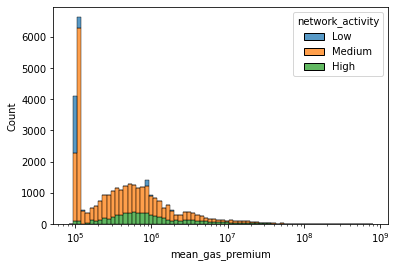

In [12]:
sns.histplot(data=df, x='mean_gas_premium', log_scale=True, hue='network_activity', multiple='stack')

Our assumption was correct. There is a positive skew with most of the tip fee (gas premium) priced at a low 10^5 attoFIL / GasUnit. This occured almost exclusively during periods of low and medium network activity. 

As expected, high network activity was associated with higher tip fees. However, medium network activity was also associated with higher tip fees. This could either be a result of participants bidding for block placement or an unintended consequence of the boundaries chosen for the network activity category labels.

Curiously, there were a small number of higher tip fees (~10^6) during a low network activity regime. Perhaps it was very important that these messages received priority in block placement. It would be interesting to identify these messages on-chain in a follow-up analysis to attempt to determine what was going on.

##Figure 4. Gas Overestimation

According to the [documentation](https://docs.filecoin.io/about-filecoin/how-filecoin-works/#gas-fees), the overestimation burn parameter is *an additional amount of gas to burn that grows larger when the difference between GasLimit and GasUsage is large.* Let's see what this looked like in our dataset.

Text(0, 0.5, 'Mean overestimation burn [attoFIL]')

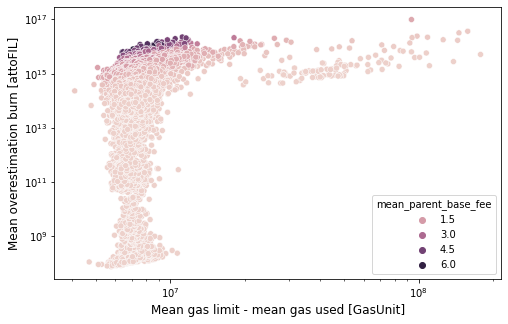

In [13]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.scatterplot(data=df, x=df['mean_gas_limit']-df['mean_gas_used'], y="mean_over_estimation_burn", hue="mean_parent_base_fee")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Mean gas limit - mean gas used [GasUnit]", size = 12)
ax.set_ylabel("Mean overestimation burn [attoFIL]", size = 12)

Now let's see the same plot color-coded with our network activity category.

Text(0, 0.5, 'Mean overestimation burn [attoFIL]')

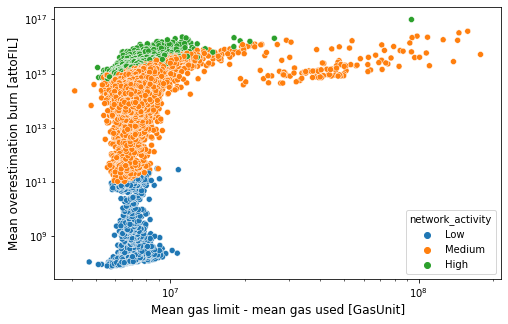

In [14]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.scatterplot(data=df, x=df['mean_gas_limit']-df['mean_gas_used'], y='mean_over_estimation_burn', hue='network_activity')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Mean gas limit - mean gas used [GasUnit]", size = 12)
ax.set_ylabel("Mean overestimation burn [attoFIL]", size = 12)

It's clear that as the network activity increased, the mean overestimation burn also increased. This makes sense because the lower prices that low network activity brings would naturally lead to a lower amount of attoFIL burned due to overestimation. The opposite is true of higher prices during high network activity.

The overestimation in GasUnits was generally kept relatively small. This suggests gas limit estimates were fairly accurate. However, during periods of mostly medium network activity, there were instances of larger gas overestimation which translated to a high burn. These are examples where the gas estimation provided by software either was not as accurate or when users manually overrode the estimate beyond what was proposed. It would be a worthwhile exercise to dig further into these timeframes on-chain to better understand what was going on.

##Future Directions



1.   Follow-up analysis of the higher tip fees during low network activity regimes
> If the EIP mechanism is working as intended, the tip fee should not go too high as people shouldn’t need to compete for priority block space since the base fee should take care of that. Only when the network is at max capacity do the tip fee bids determine block placement. So, it's odd that there were instances of higher tip fees during times when network activity was relatively low.
2.   Follow-up analysis of the higher gas overestimation during mostly medium network activity
> This is important because according to Roughgarden, the original motivation for EIP 1559 was to make it easier for users to know how much to pay in transaction fees, thereby minimizing overpayment. Gas overestimation leads to overpayment and should be minimized when EIP 1559 is working as intended
3.   Analyze total gas cost for a message over time
> This could be used to identify times of the day when total gas spent was high or low. It could be visualized with respect to the level of network activity. There may be certain times of the day when network activity peaks and total gas cost goes up. This would be considered normal behavior. However, it would be worth exploring if gas costs went up during periods of low or medium network activity or during a time of day that didn't previously exhibit higher costs.
4.   Determine whether there are any instances of 0 gas. This would mean 0 block fee and tip.
> If so, this could be evidence of off chain collusion where payment is made off chain to a miner. It can’t be tested with the current dataset since it contains average values. It would require a full dataset comprised of individual block data, not averages. 
5.   Determine whether it's possible to predict network demand and which factors contribute to the prediction
> Machine learning could be used to see whether there is an upcoming regime change in the network from a low to medium or high level of network activity.
Practically, one could start with simple models like logistic regression, where it is more straightforward to identify each parameter's contribution. The parent base fee would be used as a proxy for network activity.
Because the next block's base fee is calculated using a deterministic function, this would likely only be useful if the model could accurately predict several blocks into the future.
If network activity could be predicted, resource allocation could be modulated according to need where appropriate, creating a more efficient system.
6.   Model the gas dynamics using spectral decomposition
> Observe the power of frequencies at different times for different parameters.
Identify which parameters exhibit synchrony at which frequencies.
This could lead to real-time prediction of gas parameters. If parameters were predictable, gas estimates could be more accurate and resource allocation more targeted for different levels of network activity.











